# Autoencoder Model for HAI Security Dataset Anomaly Detection

This notebook implements a deep autoencoder for anomaly detection on the HAI security dataset. Autoencoders are effective for anomaly detection as they learn to compress and reconstruct normal data, with anomalies typically having higher reconstruction errors.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import time
import joblib
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available for training")
    # Set memory growth to avoid memory allocation errors
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU available, using CPU for training")

2025-03-04 16:12:38.675461: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 16:12:38.707314: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-04 16:12:38.707337: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-04 16:12:38.707364: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 16:12:38.714419: I tensorflow/core/platform/cpu_feature_g

Num GPUs Available:  1
GPU is available for training


## 1. Load Preprocessed Data

First, let's load the preprocessed data created in the preprocessing notebook.

In [2]:
def load_processed_data(file_path):
    """
    Load processed data from NPZ file.
    
    Args:
        file_path: Path to the NPZ file
        
    Returns:
        DataFrame: Loaded data
    """
    # Load NPZ file
    npz_data = np.load(file_path, allow_pickle=True)
    
    # Convert to DataFrame
    df = pd.DataFrame(npz_data['data'], columns=npz_data['columns'])
    
    return df

In [4]:
# Load preprocessor
preprocessor_path = './models/hai_hai_20.07_standard_preprocessor.joblib'
preprocessor_dict = joblib.load(preprocessor_path)

# Extract important information
feature_columns = preprocessor_dict['feature_columns']
attack_columns = preprocessor_dict['attack_columns']
timestamp_col = preprocessor_dict['timestamp_col']

print(f"Number of features: {len(feature_columns)}")
print(f"Attack columns: {attack_columns}")
print(f"Timestamp column: {timestamp_col}")

Number of features: 59
Attack columns: ['attack', 'attack_P1', 'attack_P2', 'attack_P3']
Timestamp column: time


In [5]:
# Get list of processed data files
train_data_dir = './processed_data/hai-20.07/train'
test_data_dir = './processed_data/hai-20.07/test'

train_files = sorted(glob.glob(f'{train_data_dir}/*.npz'))
test_files = sorted(glob.glob(f'{test_data_dir}/*.npz'))

print(f"Training files: {[os.path.basename(f) for f in train_files]}")
print(f"Test files: {[os.path.basename(f) for f in test_files]}")

Training files: ['train1_chunk0.npz', 'train1_chunk1.npz', 'train1_chunk2.npz', 'train1_chunk3.npz', 'train2_chunk0.npz', 'train2_chunk1.npz', 'train2_chunk2.npz']
Test files: ['test1_chunk0.npz', 'test1_chunk1.npz', 'test1_chunk2.npz', 'test2_chunk0.npz', 'test2_chunk1.npz']


## 2. Prepare Data for Autoencoder

Like Random Forest, the autoencoder doesn't require sequence data. We'll use individual time points as samples.

In [6]:
def load_and_prepare_tabular_data(file_paths, feature_cols, target_col=None, max_files=None, sample_fraction=None):
    """
    Load and prepare tabular data from multiple files.
    
    Args:
        file_paths: List of file paths
        feature_cols: List of feature column names
        target_col: Target column name (None for unsupervised learning)
        max_files: Maximum number of files to load (None for all files)
        sample_fraction: Fraction of data to sample (None for all data)
        
    Returns:
        tuple: (X, y) - Features and targets
    """
    all_X = []
    all_y = [] if target_col is not None else None
    
    # Limit the number of files if specified
    if max_files is not None:
        file_paths = file_paths[:max_files]
    
    for file_path in file_paths:
        print(f"Processing {os.path.basename(file_path)}...")
        
        # Load data
        df = load_processed_data(file_path)
        
        # Sample data if specified
        if sample_fraction is not None and sample_fraction < 1.0:
            df = df.sample(frac=sample_fraction, random_state=42)
        
        # Extract features
        X = df[feature_cols]
        all_X.append(X)
        
        # Extract target if provided
        if target_col is not None and target_col in df.columns:
            y = df[target_col]
            all_y.append(y)
    
    # Combine data from all files
    combined_X = pd.concat(all_X) if all_X else pd.DataFrame()
    combined_y = pd.concat(all_y) if all_y else None
    
    return combined_X, combined_y

In [7]:
# Set parameters
target_col = 'attack' if attack_columns else None  # Target column
sample_fraction = 0.1  # Sample 10% of data to reduce memory usage

# Load and prepare training data
print("Loading and preparing training data...")
X_train, _ = load_and_prepare_tabular_data(train_files, feature_columns, target_col=None, 
                                          max_files=2, sample_fraction=sample_fraction)

# Load and prepare test data
print("\nLoading and preparing test data...")
X_test, y_test = load_and_prepare_tabular_data(test_files, feature_columns, target_col=target_col, 
                                              max_files=2, sample_fraction=sample_fraction)

print(f"\nTraining data shape: {X_train.shape}")
if y_test is not None:
    print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")
else:
    print(f"Test data shape: {X_test.shape}")

Loading and preparing training data...
Processing train1_chunk0.npz...
Processing train1_chunk1.npz...

Loading and preparing test data...
Processing test1_chunk0.npz...
Processing test1_chunk1.npz...

Training data shape: (20000, 59)
Test data shape: (20000, 59), Test labels shape: (20000,)


## 3. Build Autoencoder Model

Now we'll build a deep autoencoder model for anomaly detection.

In [8]:
def build_autoencoder(input_dim, encoding_dim=16, hidden_layers=[128, 64, 32]):
    """
    Build a deep autoencoder model.
    
    Args:
        input_dim: Dimension of input data
        encoding_dim: Dimension of the encoded representation
        hidden_layers: List of hidden layer dimensions
        
    Returns:
        tuple: (model, encoder, decoder) - Full model, encoder part, and decoder part
    """
    # Encoder
    encoder_input = Input(shape=(input_dim,), name='encoder_input')
    
    # Build encoder layers
    x = encoder_input
    for i, units in enumerate(hidden_layers):
        x = Dense(units, activation='relu', name=f'encoder_dense_{i+1}')(x)
        x = BatchNormalization(name=f'encoder_bn_{i+1}')(x)
        x = Dropout(0.2, name=f'encoder_dropout_{i+1}')(x)
    
    # Bottleneck layer
    encoder_output = Dense(encoding_dim, activation='relu', name='encoder_output')(x)
    
    # Create encoder model
    encoder = Model(encoder_input, encoder_output, name='encoder')
    
    # Decoder
    decoder_input = Input(shape=(encoding_dim,), name='decoder_input')
    
    # Build decoder layers (reverse of encoder)
    x = decoder_input
    for i, units in enumerate(reversed(hidden_layers)):
        x = Dense(units, activation='relu', name=f'decoder_dense_{i+1}')(x)
        x = BatchNormalization(name=f'decoder_bn_{i+1}')(x)
        x = Dropout(0.2, name=f'decoder_dropout_{i+1}')(x)
    
    # Output layer
    decoder_output = Dense(input_dim, activation='linear', name='decoder_output')(x)
    
    # Create decoder model
    decoder = Model(decoder_input, decoder_output, name='decoder')
    
    # Create autoencoder model
    autoencoder_input = Input(shape=(input_dim,), name='autoencoder_input')
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded)
    autoencoder = Model(autoencoder_input, decoded, name='autoencoder')
    
    return autoencoder, encoder, decoder

In [9]:
# Convert data to numpy arrays and ensure float32 type
X_train_array = X_train.values.astype('float32')
X_test_array = X_test.values.astype('float32')

# Set model parameters
input_dim = X_train.shape[1]  # Number of features
encoding_dim = 16  # Dimension of the encoded representation
hidden_layers = [128, 64, 32]  # Hidden layer dimensions

# Build model
autoencoder, encoder, decoder = build_autoencoder(input_dim, encoding_dim, hidden_layers)

# Compile model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Print model summary
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 autoencoder_input (InputLa  [(None, 59)]              0         
 yer)                                                            
                                                                 
 encoder (Functional)        (None, 16)                19440     
                                                                 
 decoder (Functional)        (None, 59)                19483     
                                                                 
Total params: 38923 (152.04 KB)
Trainable params: 38027 (148.54 KB)
Non-trainable params: 896 (3.50 KB)
_________________________________________________________________


2025-03-04 16:13:11.857903: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78773 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1c:00.0, compute capability: 8.0


## 4. Train Autoencoder Model

Now we'll train the autoencoder on normal data to learn the normal behavior patterns.

In [10]:
# Set training parameters
batch_size = 256
epochs = 50
validation_split = 0.1

# Create model checkpoint callback
os.makedirs('./models', exist_ok=True)
checkpoint_path = './models/autoencoder_hai_20_07.h5'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# Create early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10, 
                              verbose=1, 
                              mode='min', 
                              restore_best_weights=True)

# Create TensorBoard callback
log_dir = './logs/autoencoder_' + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, 
                         histogram_freq=1, 
                         write_graph=True, 
                         write_images=True)

# Combine callbacks
callbacks = [checkpoint, early_stopping, tensorboard]

In [11]:
# Train model
start_time = time.time()

history = autoencoder.fit(
    X_train_array, X_train_array,  # Input and output are the same for autoencoder
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

Epoch 1/50


2025-03-04 16:13:12.181651: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-03-04 16:13:14.851588: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xc07a730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-04 16:13:14.851620: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-03-04 16:13:14.857966: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-04 16:13:14.905993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2025-03-04 16:13:14.981763: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/71 [============================>.] - ETA: 0s - loss: 5.4138
Epoch 1: val_loss improved from inf to 1.24386, saving model to ./models/autoencoder_hai_20_07.h5
71/71 [==============================] - 6s 20ms/step - loss: 5.4016 - val_loss: 1.2439
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 1.7813
Epoch 2: val_loss did not improve from 1.24386
71/71 [==============================] - 1s 15ms/step - loss: 1.7813 - val_loss: 2.4854
Epoch 3/50
71/71 [==============================] - ETA: 0s - loss: 1.1346
Epoch 3: val_loss improved from 1.24386 to 0.96039, saving model to ./models/autoencoder_hai_20_07.h5
71/71 [==============================] - 1s 17ms/step - loss: 1.1346 - val_loss: 0.9604
Epoch 4/50
67/71 [===========================>..] - ETA: 0s - loss: 0.9344
Epoch 4: val_loss improved from 0.96039 to 0.52709, saving model to ./models/autoencoder_hai_20_07.h5
71/71 [==============================] - 1s 16ms/step - loss: 0.9290 - val_loss: 0.5271
Epoch 5/50

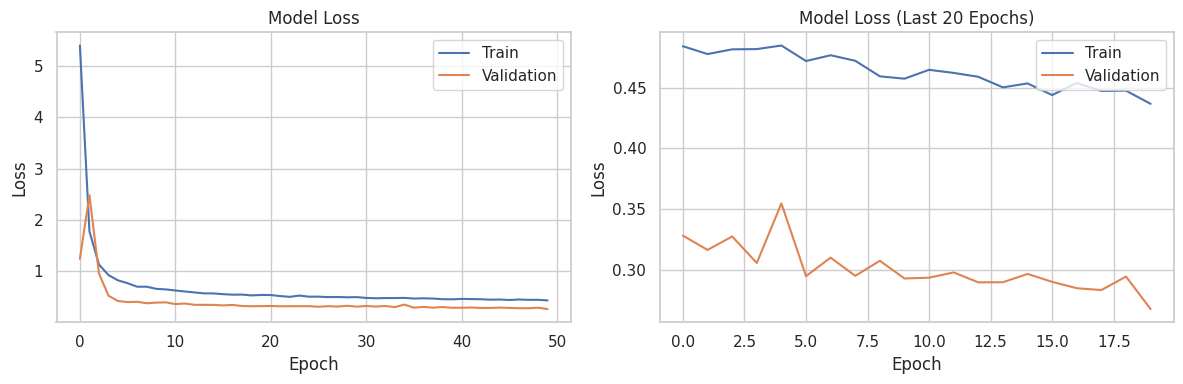

In [12]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot zoomed-in view of the last epochs
plt.subplot(1, 2, 2)
last_epochs = min(20, len(history.history['loss']))  # Last 20 epochs or all if less
plt.plot(history.history['loss'][-last_epochs:])
plt.plot(history.history['val_loss'][-last_epochs:])
plt.title(f'Model Loss (Last {last_epochs} Epochs)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

## 5. Evaluate Model and Detect Anomalies

Now we'll use the trained autoencoder to detect anomalies in the test data.

In [13]:
# Load the best model
best_model = load_model(checkpoint_path)

# Predict on test data
X_test_pred = best_model.predict(X_test_array)

# Calculate reconstruction error (MSE for each sample)
mse = np.mean(np.square(X_test_array - X_test_pred), axis=1)

print(f"Reconstruction error statistics:")
print(f"Min: {np.min(mse):.6f}")
print(f"Max: {np.max(mse):.6f}")
print(f"Mean: {np.mean(mse):.6f}")
print(f"Std: {np.std(mse):.6f}")

625/625 [==============================] - 2s 2ms/step
Reconstruction error statistics:
Min: 0.656187
Max: 506.787140
Mean: 2.682101
Std: 13.614179


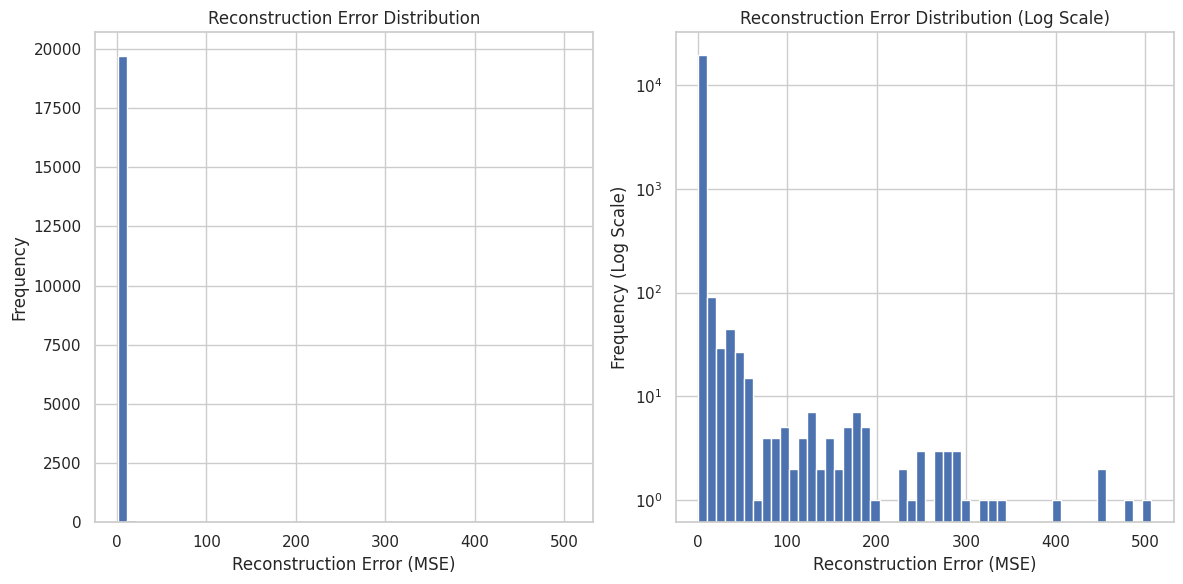

In [14]:
# Plot reconstruction error distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(mse, bins=50)
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(mse, bins=50, log=True)
plt.title('Reconstruction Error Distribution (Log Scale)')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency (Log Scale)')

plt.tight_layout()
plt.show()

### 5.1 Determine Anomaly Threshold

We need to determine a threshold for the reconstruction error to classify data points as normal or anomalous.

In [17]:
print("y_test 類型:", type(y_test))
print("y_test 形狀:", np.shape(y_test))
print("y_test 唯一值:", np.unique(y_test))

y_test 類型: <class 'pandas.core.series.Series'>
y_test 形狀: (20000,)
y_test 唯一值: [0 1]


In [18]:
print("y_test 前 10 個值:", y_test[:10])
print("mse 前 10 個值:", mse[:10])
print("y_test 是否有 NaN:", y_test.isnull().any())
print("mse 是否有 NaN:", pd.isna(mse).any())

y_test 前 10 個值: 75721    0
80184    0
19864    1
76699    0
92991    0
76434    0
84004    0
80917    0
60767    0
50074    0
Name: attack, dtype: object
mse 前 10 個值: [ 2.1546533  1.4079832 18.593582   2.0924344  1.9385026  2.3256004
  2.3450792  1.7626349  2.0165079  1.6439989]
y_test 是否有 NaN: False
mse 是否有 NaN: False


In [19]:
def find_optimal_threshold(mse, y_true):
    """
    Find the optimal threshold for anomaly detection using ROC curve.
    
    Args:
        mse: Reconstruction error values
        y_true: True labels (0 for normal, 1 for anomaly)
        
    Returns:
        float: Optimal threshold value
    """
    # Ensure y_true is a numpy array and handle potential pandas Series
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    
    # Convert to integer type to ensure proper format
    y_true = y_true.astype(int)
    
    # Ensure mse is also a numpy array
    if isinstance(mse, pd.Series):
        mse = mse.values
    
    # Check for NaN values in both inputs
    if np.isnan(y_true).any() or np.isnan(mse).any():
        raise ValueError("Inputs contain NaN values, please handle missing values")
    
    # Validate that y_true only contains binary values (0 and 1)
    unique_values = np.unique(y_true)
    if not (len(unique_values) <= 2 and set(unique_values).issubset({0, 1})):
        raise ValueError(f"y_true must contain only 0 and 1 values, but contains: {unique_values}")
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, mse)
    
    # Calculate the geometric mean of sensitivity and specificity
    gmeans = np.sqrt(tpr * (1 - fpr))
    
    # Find the optimal threshold
    ix = np.argmax(gmeans)
    optimal_threshold = thresholds[ix]
    
    print(f"Optimal threshold: {optimal_threshold:.6f}")
    print(f"At this threshold - TPR: {tpr[ix]:.4f}, FPR: {fpr[ix]:.4f}, G-mean: {gmeans[ix]:.4f}")
    
    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, marker='.')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label=f'Optimal (Threshold = {optimal_threshold:.6f})')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Calculate AUC
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.4f}")
    
    return optimal_threshold

Optimal threshold: 1.942114
At this threshold - TPR: 0.7335, FPR: 0.1816, G-mean: 0.7748


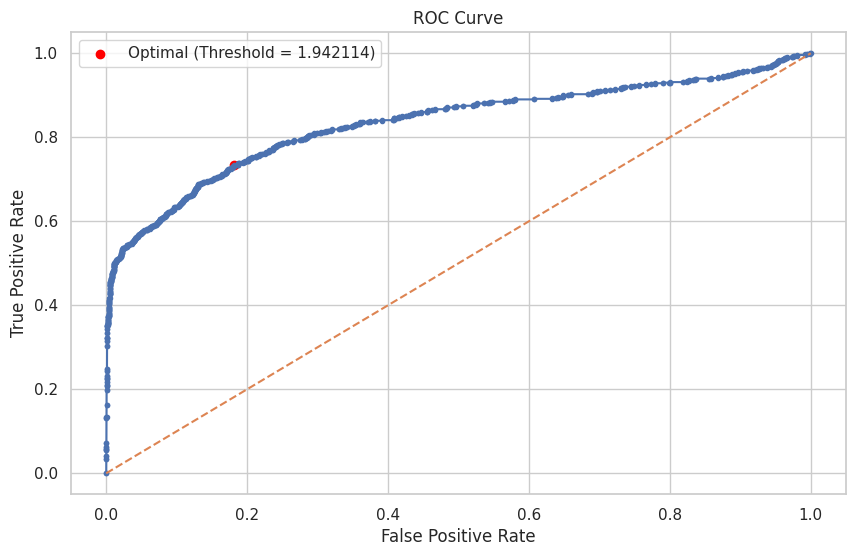

ROC AUC: 0.8338


In [20]:
# Find optimal threshold if labels are available
if y_test is not None:
    threshold = find_optimal_threshold(mse, y_test)
else:
    # If no labels, use a statistical approach
    threshold = np.mean(mse) + 3 * np.std(mse)  # Mean + 3 standard deviations
    print(f"Using statistical threshold: {threshold:.6f}")

Unique values in y_test: [0 1]
Unique values in y_pred: [0 1]


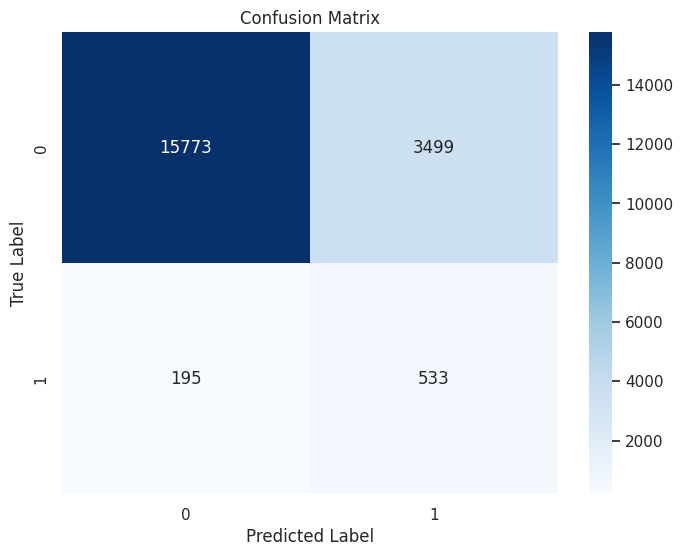

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.82      0.90     19272
           1       0.13      0.73      0.22       728

    accuracy                           0.82     20000
   macro avg       0.56      0.78      0.56     20000
weighted avg       0.96      0.82      0.87     20000



In [22]:
# Classify as anomaly if reconstruction error > threshold
y_pred = (mse > threshold).astype(int)

# Evaluate if labels are available
if y_test is not None:
    try:
        # Ensure both arrays are of the same type and format
        if isinstance(y_test, pd.Series):
            y_test_arr = y_test.values
        else:
            y_test_arr = np.array(y_test)
        
        y_pred_arr = np.array(y_pred)
        
        # Ensure both are integer type
        y_test_arr = y_test_arr.astype(int)
        y_pred_arr = y_pred_arr.astype(int)
        
        # Ensure same length
        if len(y_test_arr) != len(y_pred_arr):
            print(f"Warning: Length mismatch - y_test: {len(y_test_arr)}, y_pred: {len(y_pred_arr)}")
            min_len = min(len(y_test_arr), len(y_pred_arr))
            y_test_arr = y_test_arr[:min_len]
            y_pred_arr = y_pred_arr[:min_len]
        
        # Check for NaN values
        if np.isnan(y_test_arr).any() or np.isnan(y_pred_arr).any():
            print("Warning: NaN values detected, removing them")
            # Create a mask for non-NaN values
            mask = ~(np.isnan(y_test_arr) | np.isnan(y_pred_arr))
            y_test_arr = y_test_arr[mask]
            y_pred_arr = y_pred_arr[mask]
        
        # Validate values
        y_test_unique = np.unique(y_test_arr)
        y_pred_unique = np.unique(y_pred_arr)
        
        print(f"Unique values in y_test: {y_test_unique}")
        print(f"Unique values in y_pred: {y_pred_unique}")
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_test_arr, y_pred_arr)
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Print classification report
        print("Classification Report:")
        print(classification_report(y_test_arr, y_pred_arr))
        
    except Exception as e:
        print(f"Error during evaluation: {e}")
        print("Try running these diagnostic checks:")
        print("1. Check y_test and y_pred shapes and types")
        print("2. Verify they contain only binary values (0 and 1)")
        print("3. Look for any missing or NaN values")

### 5.2 Visualize Reconstructions

Let's visualize some examples of normal and anomalous data points with their reconstructions.

In [23]:
def plot_feature_reconstructions(X, X_pred, feature_names, indices, mse, title):
    """
    Plot original vs. reconstructed values for selected features.
    
    Args:
        X: Original data
        X_pred: Reconstructed data
        feature_names: List of feature names
        indices: Indices of samples to plot
        mse: Reconstruction errors
        title: Plot title
    """
    # Select top features with highest reconstruction error
    feature_mse = np.mean(np.square(X[indices] - X_pred[indices]), axis=0)
    top_features_idx = np.argsort(feature_mse)[-5:]  # Top 5 features
    
    # Plot each sample
    for i, idx in enumerate(indices):
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"{title} - Sample {i+1} (MSE: {mse[idx]:.6f})")
        
        for j, feature_idx in enumerate(top_features_idx):
            plt.subplot(1, 5, j+1)
            
            # Plot original and reconstructed values
            plt.bar([0, 1], [X[idx, feature_idx], X_pred[idx, feature_idx]], 
                   color=['blue', 'orange'])
            
            plt.title(f"{feature_names[feature_idx]}")
            plt.xticks([0, 1], ['Original', 'Reconstructed'])
            plt.ylabel('Value')
            
            # Add reconstruction error
            error = np.abs(X[idx, feature_idx] - X_pred[idx, feature_idx])
            plt.annotate(f"Error: {error:.4f}", xy=(0.5, 0.9), xycoords='axes fraction', 
                        ha='center', va='center', bbox=dict(boxstyle='round', fc='yellow', alpha=0.3))
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

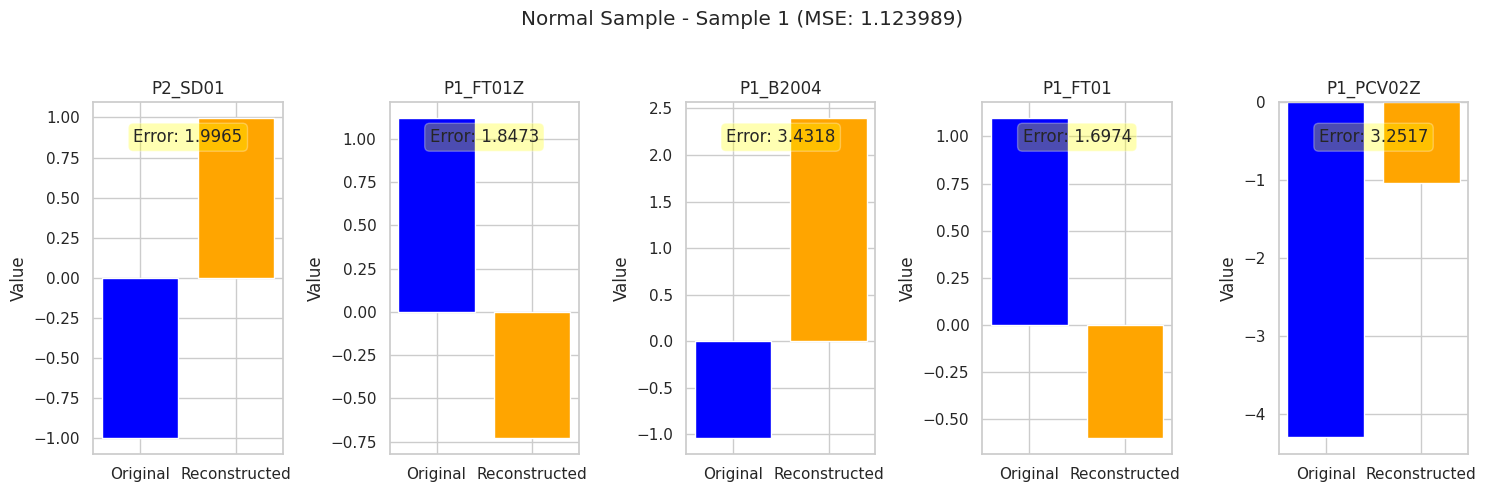

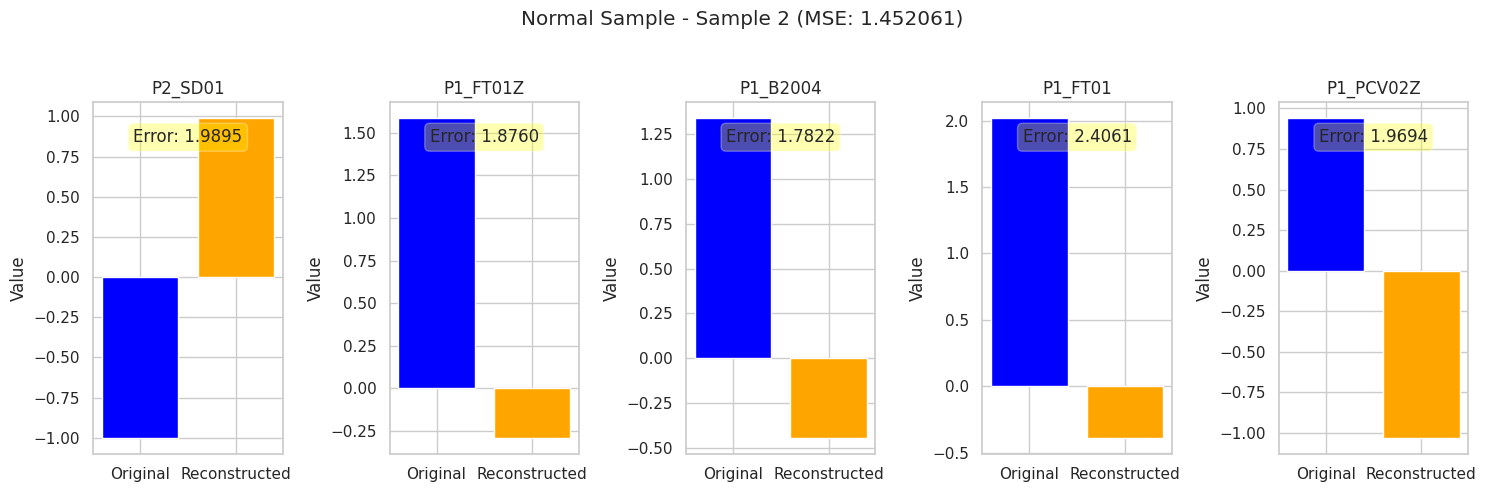

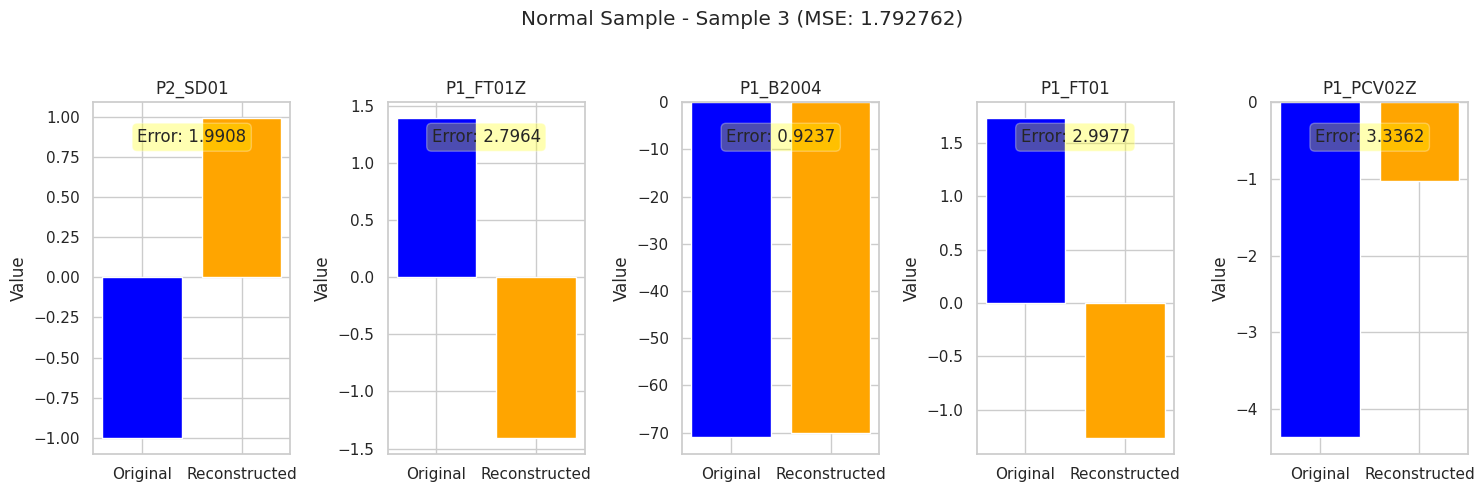

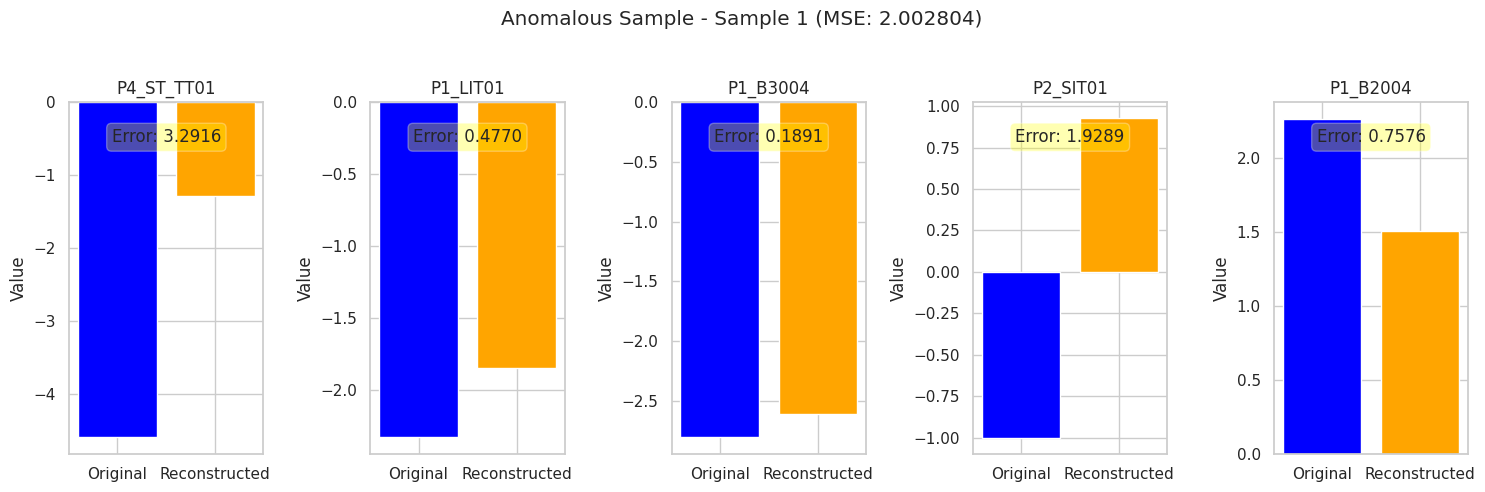

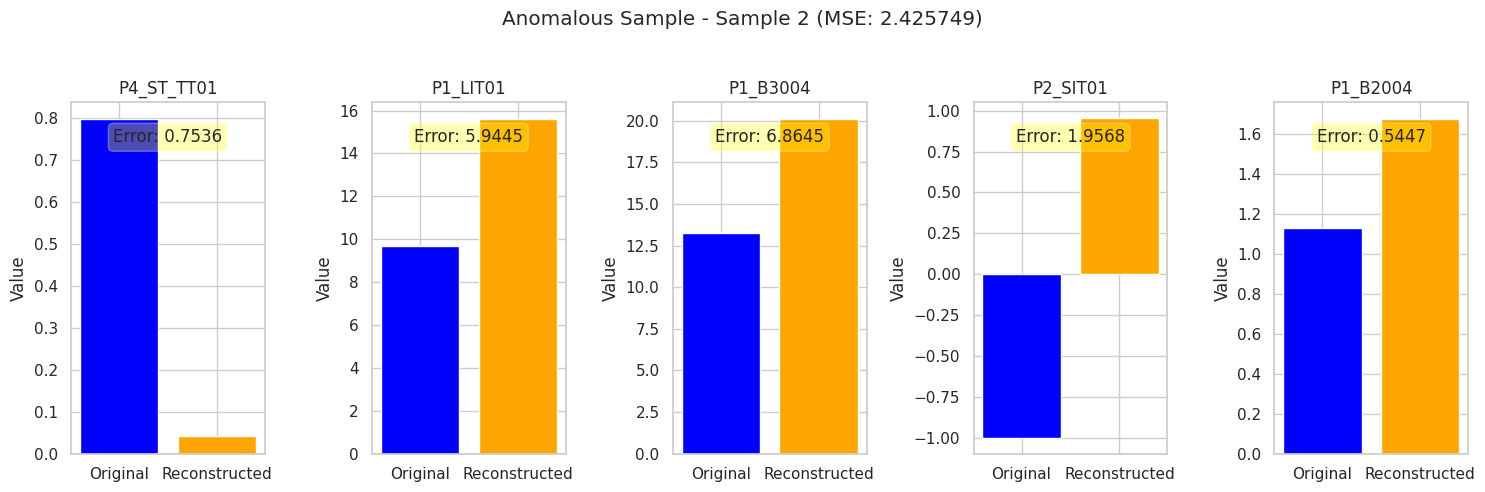

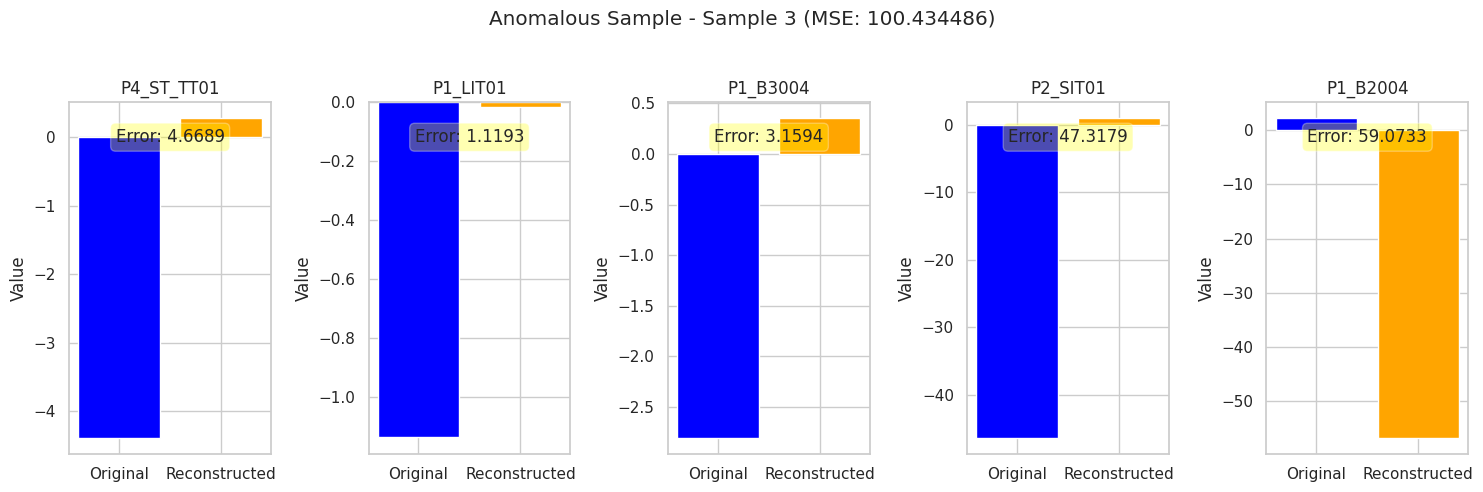

In [24]:
# Get indices of normal and anomalous samples
normal_indices = np.where(y_pred == 0)[0]
anomaly_indices = np.where(y_pred == 1)[0]

# Select random samples
num_samples = 3
selected_normal = np.random.choice(normal_indices, size=min(num_samples, len(normal_indices)), replace=False)
selected_anomaly = np.random.choice(anomaly_indices, size=min(num_samples, len(anomaly_indices)), replace=False)

# Plot normal samples
if len(selected_normal) > 0:
    plot_feature_reconstructions(X_test_array, X_test_pred, X_test.columns, selected_normal, mse, "Normal Sample")

# Plot anomalous samples
if len(selected_anomaly) > 0:
    plot_feature_reconstructions(X_test_array, X_test_pred, X_test.columns, selected_anomaly, mse, "Anomalous Sample")

### 5.3 Analyze Feature Reconstruction Errors

Let's analyze which features have the highest reconstruction errors in anomalies.

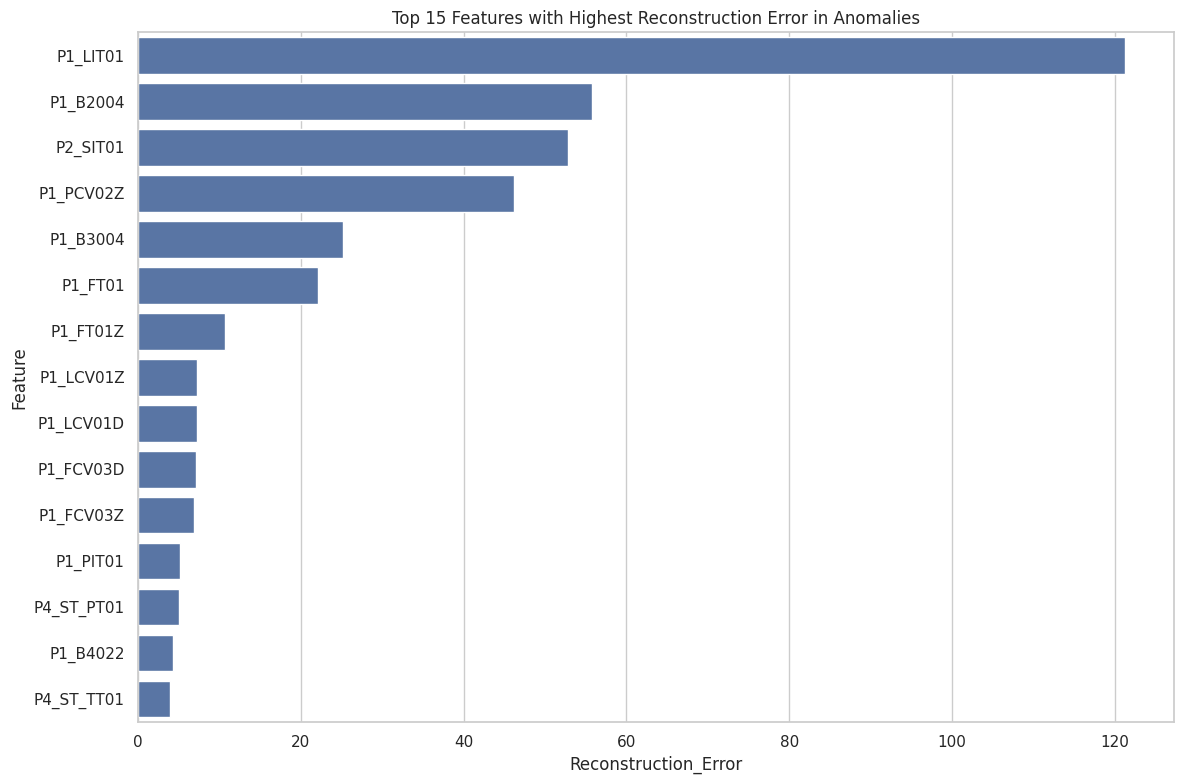

Top 10 features with highest reconstruction error in anomalies:
1. P1_LIT01: 121.192886
2. P1_B2004: 55.822208
3. P2_SIT01: 52.789780
4. P1_PCV02Z: 46.177525
5. P1_B3004: 25.221521
6. P1_FT01: 22.065245
7. P1_FT01Z: 10.742235
8. P1_LCV01Z: 7.288705
9. P1_LCV01D: 7.256880
10. P1_FCV03D: 7.081964


In [25]:
# Get indices of anomalies
anomaly_indices = np.where(y_pred == 1)[0]

if len(anomaly_indices) > 0:
    # Calculate feature-wise reconstruction error for anomalies
    anomaly_feature_mse = np.mean(np.square(X_test_array[anomaly_indices] - X_test_pred[anomaly_indices]), axis=0)
    
    # Create a DataFrame for easier visualization
    feature_error_df = pd.DataFrame({
        'Feature': X_test.columns,
        'Reconstruction_Error': anomaly_feature_mse
    }).sort_values('Reconstruction_Error', ascending=False)
    
    # Plot top 15 features with highest reconstruction error
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Reconstruction_Error', y='Feature', data=feature_error_df.head(15))
    plt.title('Top 15 Features with Highest Reconstruction Error in Anomalies')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 features with highest reconstruction error in anomalies:")
    for i, (feature, error) in enumerate(zip(feature_error_df['Feature'].head(10), 
                                           feature_error_df['Reconstruction_Error'].head(10))):
        print(f"{i+1}. {feature}: {error:.6f}")
else:
    print("No anomalies detected.")

## 6. Visualize Encoded Representations

Let's visualize the encoded representations to see if anomalies form distinct clusters.

In [26]:
# Get encoder model
encoder_model = Model(inputs=best_model.input, outputs=best_model.layers[len(best_model.layers)//2-1].output)

# Get encoded representations
encoded_data = encoder_model.predict(X_test_array)

print(f"Encoded data shape: {encoded_data.shape}")

625/625 [==============================] - 0s 518us/step
Encoded data shape: (20000, 59)


Explained variance ratio: [0.85111433 0.08180357]
Total explained variance: 0.9329


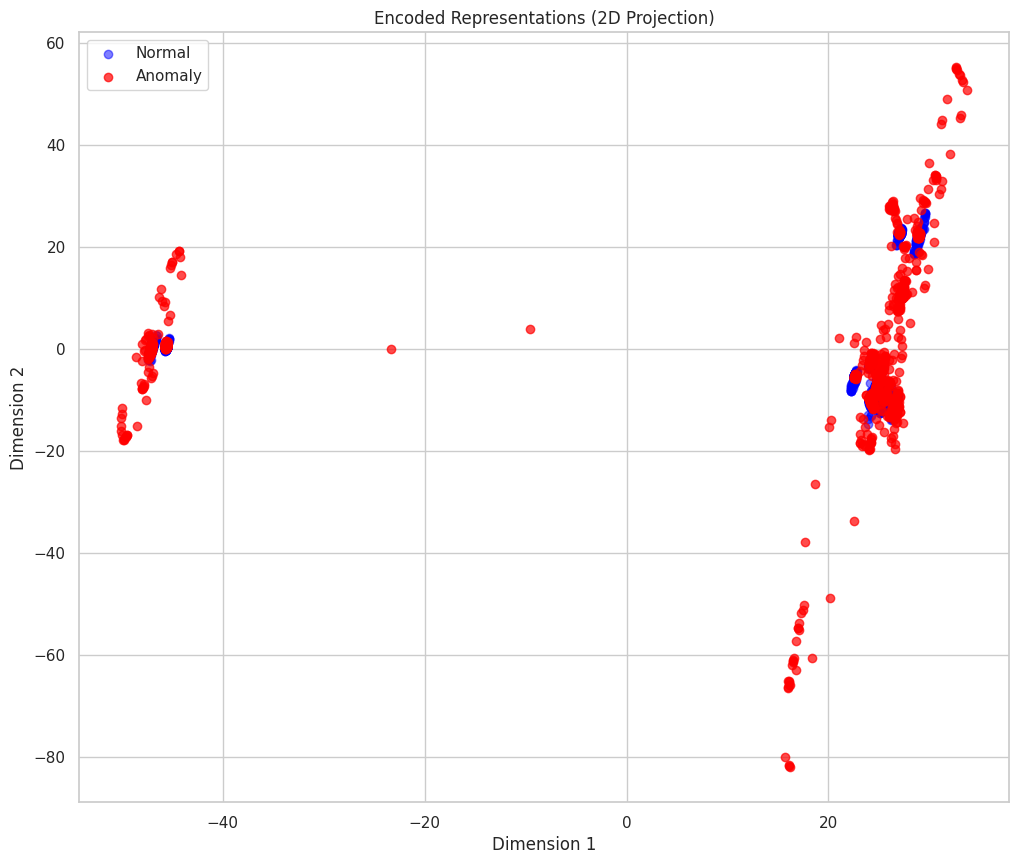

In [27]:
# Visualize encoded representations using PCA if dimension > 2
if encoded_data.shape[1] > 2:
    from sklearn.decomposition import PCA
    
    # Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    encoded_2d = pca.fit_transform(encoded_data)
    
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")
else:
    encoded_2d = encoded_data

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'x': encoded_2d[:, 0],
    'y': encoded_2d[:, 1],
    'anomaly': y_pred,
    'mse': mse
})

# Plot encoded representations
plt.figure(figsize=(12, 10))

# Plot normal and anomalous points
plt.scatter(plot_df[plot_df['anomaly'] == 0]['x'], plot_df[plot_df['anomaly'] == 0]['y'], 
           c='blue', label='Normal', alpha=0.5)
plt.scatter(plot_df[plot_df['anomaly'] == 1]['x'], plot_df[plot_df['anomaly'] == 1]['y'], 
           c='red', label='Anomaly', alpha=0.7)

plt.title('Encoded Representations (2D Projection)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

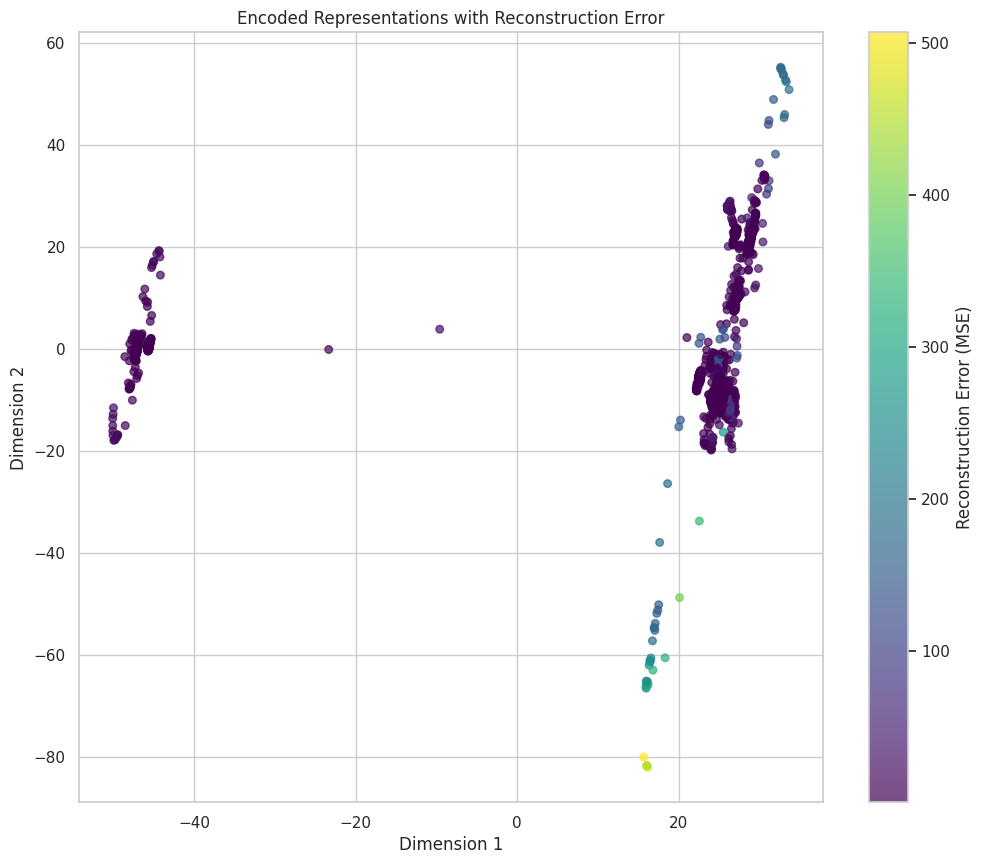

In [28]:
# Plot encoded representations with reconstruction error as color
plt.figure(figsize=(12, 10))

scatter = plt.scatter(plot_df['x'], plot_df['y'], c=plot_df['mse'], 
                     cmap='viridis', alpha=0.7, s=30)

plt.colorbar(scatter, label='Reconstruction Error (MSE)')
plt.title('Encoded Representations with Reconstruction Error')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

## 7. Save Model and Results

Finally, let's save the model and results for future use.

In [29]:
# Save encoder model
os.makedirs('./models', exist_ok=True)
encoder_model.save('./models/autoencoder_encoder_hai_20_07.h5')

# Save threshold and other metadata
model_metadata = {
    'threshold': threshold,
    'encoding_dim': encoding_dim,
    'hidden_layers': hidden_layers,
    'feature_columns': feature_columns,
    'training_history': {
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss']
    }
}

joblib.dump(model_metadata, './models/autoencoder_metadata_hai_20_07.joblib')
print("Model and metadata saved successfully.")

Model and metadata saved successfully.


## 8. Conclusion

In this notebook, we've implemented a deep autoencoder for anomaly detection on the HAI security dataset. The autoencoder learns to compress and reconstruct normal behavior patterns and identifies anomalies based on reconstruction error. Key steps included:

1. Loading and preparing preprocessed data
2. Building a deep autoencoder model
3. Training the model on normal data
4. Detecting anomalies using reconstruction error
5. Evaluating the model's performance
6. Analyzing feature reconstruction errors
7. Visualizing encoded representations

The autoencoder provides an effective approach for detecting anomalies in industrial control system data, with the added benefit of dimensionality reduction and feature learning.